# SURF简介（加速的强大功能）

### 目标
在这一章当中，
- 我们将了解SURF的基础
- 我们将在OpenCV中看到SURF函数

### 理论

在上一章中,我们看到了SIFT用于关键点检测和描述符。但相对缓慢,人们需要更多的加速版本。2006年,三个人,H .Tuytelaars,T. and Van Gool,L,发表了另一篇论文,“SURF:加速健壮的特征”,引入了一种名为“SURF”的新算法。正如名字所表明的那样,它是一个加速版本的SIFT。

在SIFT中，Lowe用高斯差近似高斯的拉普拉斯算子来寻找尺度空间。SURF走得更远，使用Box Filter近似LoG。下图显示了这种近似值的演示。这种近似的一大优点是，借助积分图像可以轻松地计算出带盒滤波器的卷积。并且可以针对不同规模并行执行。SURF还依赖于Hessian矩阵的行列式来确定尺度和位置。

![](data/surf_boxfilter.jpg)

对于方向分配，SURF在水平和垂直方向上对大小为6s的邻域使用小波响应。适当的高斯权重也适用于它。然后将它们绘制在下图所示的空间中。通过计算角度为60度的滑动方向窗口内所有响应的总和，可以估算主导方向。有趣的是，小波响应可以很容易地使用积分图像在任何规模下发现。对于许多应用，不需要旋转不变性，因此无需查找此方向，从而加快了过程。SURF提供了称为Upright-SURF或U-SURF的功能。它提高了速度，并具有高达$\pm 15^{\circ}$的鲁棒性。OpenCV根据标志支持两种方式。如果为0，则计算方向。如果为1，则不计算方向并且速度更快。

![](data/surf_orientation.jpg)

对于功能描述，SURF在水平和垂直方向上使用小波响应（同样，使用积分图像使事情变得更容易）。在s是大小的关键点周围采用大小为20sX20s的邻域。它分为4x4子区域。对于每个子区域，获取水平和垂直小波响应，并像这样形成向量，$v =(\sum dx,\sum dy,\sum |dx|,\sum |dy|)$。当表示为向量时，这将为SURF特征描述符提供总共64个维度。尺寸越小，计算和匹配速度越快，但特征的区分性更好。

为了更加独特，SURF特征描述符具有扩展的128维版本。dx和$|dx|$的和分别针对$dy<0$和$dy≥0$进行计算。同样，$dy$和$|dy|$的总和 根据$dx$的符号进行拆分，从而使特征数量加倍。它不会增加太多的计算复杂性。OpenCV通过将分别为64-dim和128-dim（默认值为128-dim）的标志的值设置为0和1来支持这两者（默认为128-dim）。

另一个重要的改进是对基础兴趣点使用了Laplacian算符（海森矩阵的迹）。它不增加计算成本，因为它已在检测期间进行了计算。拉普拉斯算子的标志将深色背景上的明亮斑点与相反的情况区分开。在匹配阶段，我们仅比较具有相同对比类型的特征（如下图所示）。这些最少的信息可加快匹配速度，而不会降低描述符的性能。

![](data/surf_matching.jpg)

简而言之，SURF添加了许多功能来提高每一步的速度。分析表明，它的速度是SIFT的3倍，而性能却与SIFT相当。SURF擅长处理具有模糊和旋转的图像，但不擅长处理视点变化和照明变化。

### OpenCV中的SURF
OpenCV提供类似于SIFT的SURF功能。您可以使用一些可选条件（例如64 / 128-dim描述符，Upright / Normal SURF等）来启动SURF对象。所有详细信息在docs中都有详细说明。然后，就像在SIFT中所做的那样，我们可以使用SURF.detect()，SURF.compute()等来查找关键点和描述符。

首先，我们将看到一个有关如何找到SURF关键点和描述符并进行绘制的简单演示。

In [1]:
# opencv 4.x 由于专利原因不支持 SURF 需要用conda建立一个Python 3.6环境并安装以下版本的OpenCV
# pip install opencv-python==3.4.2.16
# pip install opencv-contrib-python==3.4.2.16
# pip install matplotlib

import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

img = cv.imread('data/butterfly.jpg',0)

# 创建SURF对象。你可以在此处或以后指定参数。
# 这里设置海森矩阵的阈值为400
surf = cv.xfeatures2d.SURF_create(400)

# 直接查找关键点和描述符
kp, des = surf.detectAndCompute(img,None)
print(len(kp))

1330


图片中无法显示1199个关键点。我们将其减少到50左右以绘制在图像上。匹配时，我们可能需要所有这些功能，但现在不需要。因此，我们增加了海森阈值。

In [2]:
# 检查海森矩阵阈值
print( surf.getHessianThreshold() )

# 我们将其设置为50000。记住，它仅用于表示图片。 
# 在实际情况下，最好将值设为300-500
surf.setHessianThreshold(50000)

# 再次计算关键点并检查其数量。
kp, des = surf.detectAndCompute(img,None)
print( len(kp) )

400.0
48


它小于50。让我们在图像上绘制它。

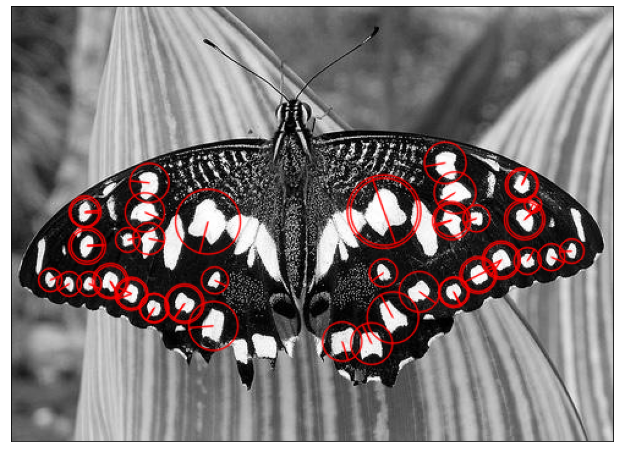

In [3]:
img2 = cv.drawKeypoints(img,kp,None,(255,0,0),4)

plt.figure(figsize=(12,8))
plt.imshow(img2)
plt.xticks([]), plt.yticks([])
plt.show()

您可以看到SURF更像是斑点检测器。它检测到蝴蝶翅膀上的白色斑点。您可以使用其他图像进行测试。

现在，我想应用U-SURF，以便它不会找到方向。

False


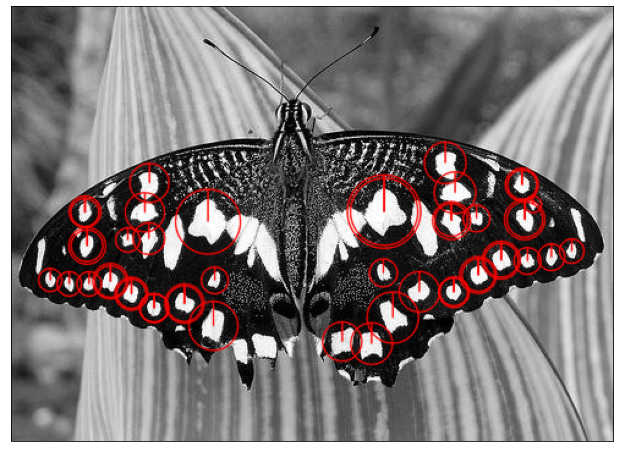

In [4]:
print( surf.getUpright() )

surf.setUpright(True)

# 重新计算特征点并绘制
kp = surf.detect(img,None)
img2 = cv.drawKeypoints(img,kp,None,(255,0,0),4)

plt.figure(figsize=(12,8))
plt.imshow(img2)
plt.xticks([]), plt.yticks([])
plt.show()

所有的方向都显示在同一个方向上。它比以前更快了。如果你工作的情况下，方向不是一个问题(如全景拼接)等，这是更好的。

最后，我们检查描述符的大小，如果只有64维，则将其更改为128。

In [5]:
# 找到算符的描述
print( surf.descriptorSize() )

# 表示flag “extened” 为False。
surf.getExtended()

# 因此，将其设为True即可获取128个尺寸的描述符。
surf.setExtended(True)
kp, des = surf.detectAndCompute(img,None)
print( surf.descriptorSize() )

print( des.shape )

64
128
(48, 128)


其余部分是匹配的，我们将在另一章中进行匹配。

### 附加资源

### 练习